In [1]:
import torch
from torch import nn
from torch import GradScaler
from torch.utils.data import random_split, DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

from tqdm.auto import tqdm

torch.manual_seed(0)
torch.__version__

'2.7.0+cpu'

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### Prepare Data


In [3]:
class CSVDataset(Dataset):
    def __init__(self, path: str, features_keys: list[str], target_keys: list[str]):
        super().__init__()

        df = pd.read_csv(path, sep=";")

        self.values = torch.tensor(
            list(zip(*[df[key].to_list() for key in features_keys])),
            dtype=torch.float32,
        )
        self.targets = torch.tensor(
            list(zip(*[df[key].to_list() for key in target_keys])), dtype=torch.float32
        )

        self.samples = [(val, targ) for val, targ in zip(self.values, self.targets)]

    def __getitem__(self, index: int):
        return self.values[index], self.targets[index]

    def __len__(self):
        return len(self.samples)

In [4]:
class DataframeDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        super().__init__()

        self.values = torch.tensor(df["x"], dtype=torch.float32)
        self.targets = torch.tensor(df["y"], dtype=torch.float32)

        self.samples = [(val, targ) for val, targ in zip(self.values, self.targets)]

    def __getitem__(self, index: int):
        return self.values[index], self.targets[index]

    def __len__(self):
        return len(self.samples)

In [5]:
class LogisticFuncDataset(Dataset):
    def __init__(self, x_start=-10, x_end=10, steps=1000, C=10, a=1, b=1):
        super().__init__()

        self.values = torch.linspace(x_start, x_end, steps)
        self.labels = C / (1 + (torch.e ** (-b * self.values)))

    def __getitem__(self, index: int):
        return self.values[index], self.labels[index]

    def __len__(self):
        return len(self.values)

In [6]:
health_df = pd.read_csv("../data/ihme_data.csv")

sensor_df = pd.read_csv("../data/openaq_data.csv")
sensor_df.dropna(axis=0, how="all", inplace=True)

df = pd.merge(health_df, sensor_df)

df.sort_values("tuberculosis", inplace=True)
df.set_index("country", inplace=True)

df[df < 0] = None
df[df["tuberculosis"] > 500] = None
df = df.dropna(how="all", subset=["pm1", "pm10", "pm25", "co", "no2", "o3", "so2"])
df

,tuberculosis,hiv,pm25,co,no2,pm1,pm10,o3,so2
country,,,,,,,,,
SM,1.988,0.015,NaN,NaN,4.960,NaN,NaN,65.400,NaN
DK,2.739,0.032,NaN,181.5,7.801,NaN,11.300,58.240,NaN
IS,2.902,0.098,3.318,116.0,5.828,2.053,6.981,20.000,2.418
NL,2.923,0.020,2.882,262.0,NaN,14.130,2.383,48.667,NaN
GR,2.999,0.047,13.377,1270.0,19.817,NaN,27.040,67.180,6.783
...,...,...,...,...,...,...,...,...,...
KE,200.422,0.719,14.200,NaN,NaN,10.900,21.700,NaN,NaN
IN,212.643,0.041,NaN,NaN,NaN,67.500,NaN,NaN,NaN
MG,221.561,0.213,29.100,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
point_df = df[["tuberculosis", "pm25"]].dropna(how="any")
point_df.rename(columns={"tuberculosis": "x", "pm25": "y"}, inplace=True)

dataset = DataframeDataset(point_df)
point_df

C:\Users\chris\AppData\Local\Temp\ipykernel_8120\4196196558.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.values = torch.tensor(df["x"], dtype=torch.float32)
C:\Users\chris\AppData\Local\Temp\ipykernel_8120\4196196558.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.targets = torch.tensor(df["y"], dtype=torch.float32)


,x,y
country,,
IS,2.902,3.318
NL,2.923,2.882
GR,2.999,13.377
FI,3.131,4.324
CY,3.153,14.111
...,...,...
RW,181.084,40.300
KE,200.422,14.200
MG,221.561,29.100


<Axes: xlabel='None', ylabel='None'>

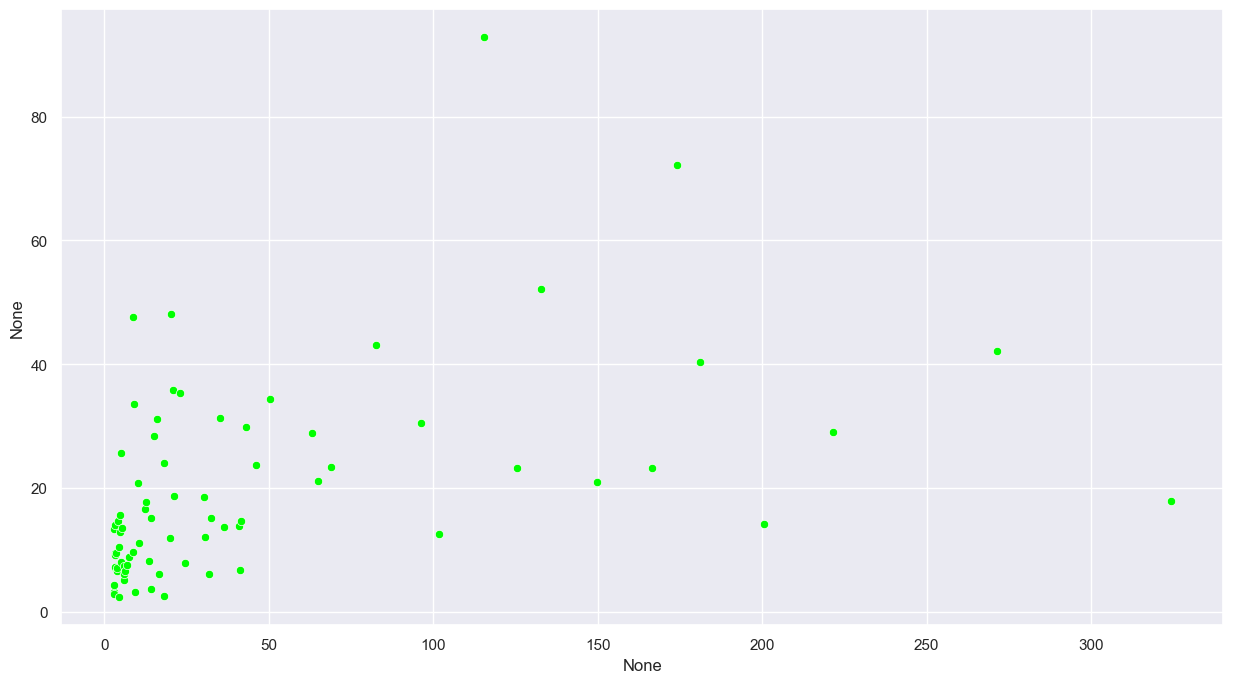

In [8]:
sns.set_theme()
plt.figure(figsize=(15, 8))

sns.scatterplot(x=dataset.values, y=dataset.targets, color="lime")

In [9]:
train_size = int(1 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size])

print(f"{len(train_data)}\n{len(test_data)}")

77
0


In [10]:
BATCH_SIZE = 1

print(f"Creating DataLoader's with batch size {BATCH_SIZE}.")

# Make dataset into dataloader
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader.dataset, test_dataloader

Creating DataLoader's with batch size 1.


(<torch.utils.data.dataset.Subset at 0x246ad14e660>,
 <torch.utils.data.dataloader.DataLoader at 0x246ad1c56d0>)

### Building Model


In [11]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_nodes=8):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, hidden_nodes)
        self.layer2 = nn.Linear(hidden_nodes, hidden_nodes)
        self.layer3 = nn.Linear(hidden_nodes, hidden_nodes)
        self.layer4 = nn.Linear(hidden_nodes, hidden_nodes)
        self.layer5 = nn.Linear(hidden_nodes, output_dim)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.layer5(x)

        return x

In [12]:
class ExpRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Learnable parameters
        self.a = nn.Parameter(torch.randn(1))  # a can be positive or negative
        self.log_b = nn.Parameter(
            torch.randn(1)
        )  # Learning log_b instead of b directly

    def forward(self, X):
        b = torch.exp(self.log_b)  # Ensures b is always positive, allows b < 1
        return self.a * torch.pow(b, X)  # a * b^x

    def __str__(self):
        return f"$f(x) = {float(self.a):.3f} * {float(torch.exp(self.log_b)):.3f}^x$"

In [13]:
class LogistRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Learnable parameters
        self.C = nn.Parameter(torch.randn(1))
        self.log_a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))

    def forward(self, X):
        a = torch.exp(self.log_a)
        return self.C / (1 + (a * torch.pow(torch.e, torch.neg(self.b) * X)))

    def __str__(self):
        return rf"$f(x) = \frac{{{float(self.C):.3f}}}{{1 + {float(torch.exp(self.log_a)):.3f} \cdot e^{{{float(torch.neg(self.b)):.3f}x}}}}$"

In [14]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return (self.a * x) + self.b

    def __str__(self):
        return f"$f(x) = {float(self.a):.3f}x + {float(self.b):.3f}$"

In [15]:
class QuadraticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return (self.a * torch.pow(x, 2)) + (self.b * x) + self.c

    def __str__(self):
        return f"$f(x) = {float(self.a):.3f}x^2 + {float(self.b):.3f}x + {float(self.c):.3f}$"

In [16]:
model = LinearRegressionModel().to(device)
str(model)

'$f(x) = 0.273x + -0.918$'

### Loss and Optimizer


In [17]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

scaler = GradScaler(device=str(device))

### Train Model


In [18]:
epochs = 1000

train_loss = test_loss = 0


for epoch in tqdm(range(epochs)):

    model.train()

    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        with torch.autocast(device_type=device.type, dtype=torch.float16):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

        scaler.scale(loss).backward()

        scaler.step(optimizer)

        scaler.update()

        optimizer.zero_grad(set_to_none=True)

    train_loss = train_loss / len(train_dataloader)

    if len(test_data) > 0:
        model.eval()

        test_loss = 0
        with torch.inference_mode():
            for batch, (X, y) in enumerate(test_dataloader):
                with torch.autocast(device_type=device.type, dtype=torch.float16):
                    X, y = X.to(device), y.to(device)
                    test_pred_logits = model(X)
                    loss = loss_fn(test_pred_logits, y)
                    test_loss += loss.item()

        test_loss = test_loss / len(test_dataloader)

    if (epoch+1) % 50 == 0:

        tqdm.write(
            f"      Epoch: {epoch+1}  |  "
            f"train_loss: {train_loss:.4f}  |  "
            f"test_loss: {test_loss:.4f}  |  "
        )

  0%|          | 0/1000 [00:00<?, ?it/s]

      Epoch: 50  |  train_loss: 921.3026  |  test_loss: 0.0000  |  
      Epoch: 100  |  train_loss: 378.4176  |  test_loss: 0.0000  |  
      Epoch: 150  |  train_loss: 363.0612  |  test_loss: 0.0000  |  
      Epoch: 200  |  train_loss: 521.7460  |  test_loss: 0.0000  |  
      Epoch: 250  |  train_loss: 241.4642  |  test_loss: 0.0000  |  
      Epoch: 300  |  train_loss: 338.2532  |  test_loss: 0.0000  |  
      Epoch: 350  |  train_loss: 434.3601  |  test_loss: 0.0000  |  
      Epoch: 400  |  train_loss: 213.0513  |  test_loss: 0.0000  |  
      Epoch: 450  |  train_loss: 292.3755  |  test_loss: 0.0000  |  
      Epoch: 500  |  train_loss: 750.4348  |  test_loss: 0.0000  |  
      Epoch: 550  |  train_loss: 286.7184  |  test_loss: 0.0000  |  
      Epoch: 600  |  train_loss: 234.7043  |  test_loss: 0.0000  |  
      Epoch: 650  |  train_loss: 279.7690  |  test_loss: 0.0000  |  
      Epoch: 700  |  train_loss: 349.7443  |  test_loss: 0.0000  |  
      Epoch: 750  |  train_loss: 51

$f(x) = 0.263x + 14.734$


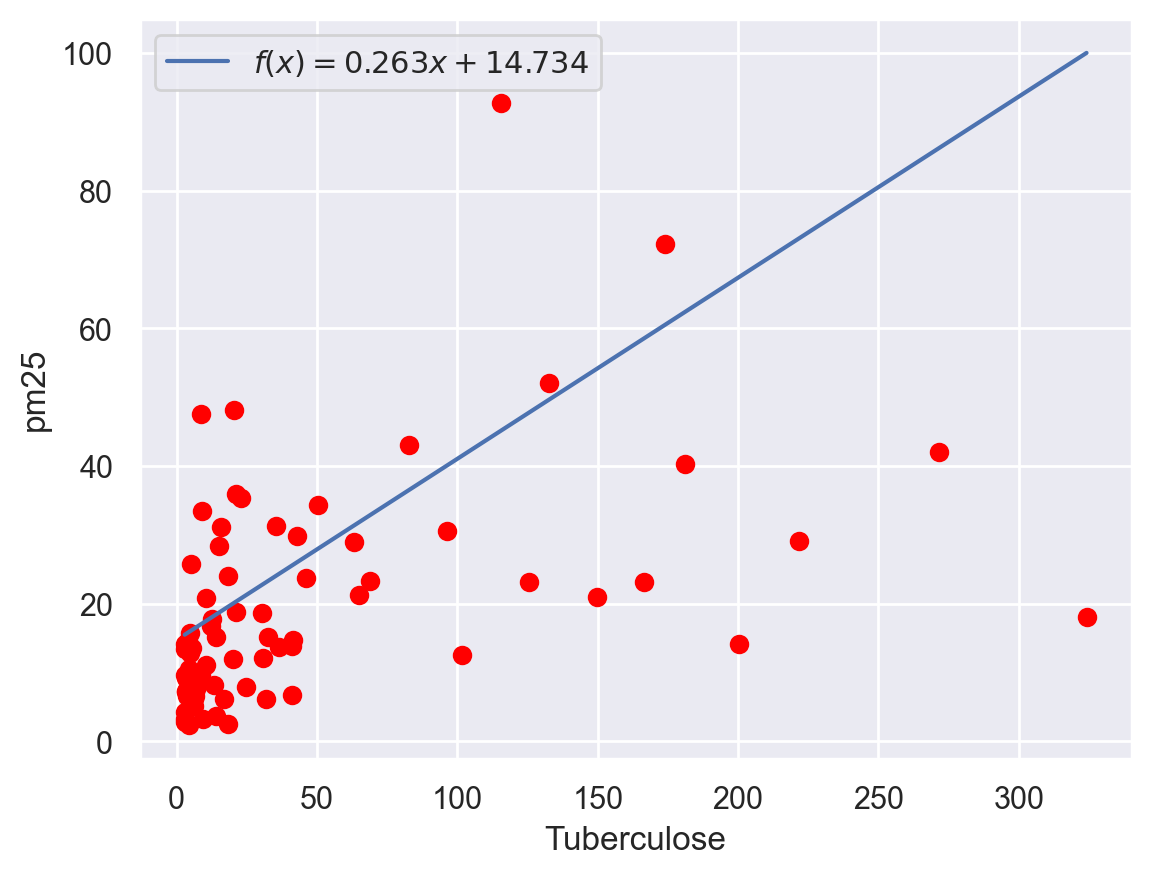

In [20]:
model.eval()

x_vals = torch.linspace(dataset.values[0].squeeze(), dataset.values[-1].squeeze(), 100)

with torch.inference_mode():
    y_preds = [model(val.unsqueeze(dim=0)) for val in x_vals]

print(str(model))

plt.figure(dpi=200)
plt.scatter(dataset.values, dataset.targets, color="red")
plt.plot(x_vals, y_preds, label=str(model))
plt.xlabel("Tuberculose")
plt.ylabel("pm25")
plt.legend()
plt.show()